$$
\begin{array}{c}
\textbf{CAUSAL INFERENCE - Fall 2025}\\\\
\textit{Center for Data Science, New York University} \\\\
\textit{October 24, 2025}\\\\\
\text{ Prepared by: Vivek Kumar Agarwal}\\\\
\textbf{Recitation 8: Natural Experiments and Control Varaibles }\\\\
\end{array}
$$



![Causal Inference](../figures/CI_lab7_image1.png)

---

## Today's Recitation 

- Natural Experiments
- Control Variables
- Lets Code!!

---

## Natural Experiments 


### Causality from Observational Data

#### The Challenge

**Question**: Does going to college increase lifetime earnings?

Simply comparing college graduates vs. non-graduates doesn't answer this causally. Why? College attendees differ in ability, family background, motivation - all of which also affect earnings.

### Why Experiments Work

RCTs solve this by randomly assigning treatment $S$ (e.g., getting treatment vs. control), creating independence from unobserved confounders $U$ (all the factors that affect both treatment choice and outcomes):
$$S \perp U$$

Treatment and control groups are similar in all characteristics (observed and unobserved).

**Problem**: RCTs are expensive, time-consuming, sometimes unethical. We can't always randomize.

Yet we have massive observational data: health records, labor markets, financial data, social media.

### Two Approaches for Causal Inference from Observational Data

1. **Natural Experiments**: Treatment assigned "as-if" randomly by nature/institutions/policy
2. **Controlling for Confounders**: Measure and adjust for differences between groups

---

Today: **Natural Experiments**

---

### Natural Experiment - what is it?

- Some process outside our control assigns treatment in a way that is plausibly random (or as-if random). This mimics the key feature of RCTs: $S \perp U$.

- In other words, Treatment is assigned by some external process that mimics randomization.

**Key requirements:**
1. **As-if random assignment**: $S \perp U$ (or conditional on controls)
2. **SUTVA**: One person's treatment doesn't affect another's outcome (no spillovers)
3. **Relevance**: The randomization must actually affect treatment


**Example: Vietnam Draft Lottery**
- Birthdays randomly assigned lottery numbers (1-365)
- Random lottery number $\perp$ ability, family background, motivation




---

### Random vs. Non-random Assignment

Let's see the difference between random and non-random treatment assignment with a simple simulation.

**Setup:**
- **Random assignment**: Treatment is assigned by coin flip (independent of everything)
- **Non-random assignment**: Treatment depends on a confounder $U$ that also affects the outcome

Why does this matter? In random assignment, treatment and control groups are similar. In non-random assignment, they differ systematically - the confounder creates selection bias.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Random treatment assignment
np.random.seed(201)
N = 500
treatment = np.random.binomial(1, 0.5, N)
data_random = pd.DataFrame({
    'treatment': treatment,
    'outcome': np.random.normal(0, 1, N) + 2 * treatment
})

# Non-random treatment assignment based on a confounder
confounder = np.random.normal(0, 1, N)
treatment = (confounder > 0).astype(int)  # treatment depends on U
data_non_random = pd.DataFrame({
    'confounder': confounder,
    'treatment': treatment,
    'outcome': confounder + 2 * treatment + np.random.normal(0, 1, N)
})

print("Random assignment")
print(data_random.head(10))
print("\nNon-random assignment")
print(data_non_random.head(10))

Random assignment
   treatment   outcome
0          0  0.208307
1          1  1.365955
2          1  0.343714
3          1  0.916081
4          1  0.350137
5          0  0.383980
6          0  0.292093
7          0  1.160619
8          0 -0.296647
9          0 -0.679880

Non-random assignment
   confounder  treatment   outcome
0   -0.125056          0 -1.547934
1    1.496612          1  3.965643
2    0.220468          1  2.315961
3    0.011191          1  1.991408
4   -0.378124          0  0.156474
5   -2.436663          0 -2.242509
6    0.223760          1  2.870007
7   -0.553656          0  1.051514
8    0.048394          1  1.850523
9    0.226738          1  3.058482


**What do you see above ?**
- Random assignment: Treatment is 0 or 1 independent of anything else
- Non-random assignment: Treatment is 1 when confounder > 0. Since confounder also affects outcome, treated and control groups differ systematically.

This is why simply comparing treated vs. control in observational data can be misleading - the groups differ in ways beyond just the treatment.

---

**Balance Test: Are Treatment and Control Groups Similar?**

A key test of random assignment is the **balance test**: Are confounders distributed the same way in treatment and control groups?

$$p(U|S=1) = p(U|S=0)$$

If treatment is truly random, this should hold - the confounder $U$ should look the same across groups.

Let's check the non-random assignment case:

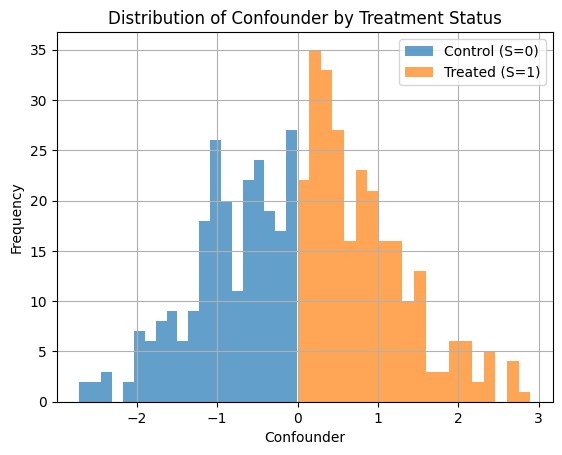

           count      mean       std       min       25%       50%       75%  \
treatment                                                                      
0          238.0 -0.856284  0.603274 -2.714763 -1.166328 -0.786254 -0.391490   
1          262.0  0.829128  0.634484  0.000376  0.328510  0.704035  1.187422   

                max  
treatment            
0         -0.005233  
1          2.898446  


In [2]:
# Distributions of confounder given treatment
data_non_random.groupby('treatment')['confounder'].hist(alpha=0.7, bins=20)
plt.xlabel('Confounder')
plt.ylabel('Frequency')
plt.legend(['Control (S=0)', 'Treated (S=1)'])
plt.title('Distribution of Confounder by Treatment Status')
plt.show()

# Summary statistics
print(data_non_random.groupby('treatment')['confounder'].describe())

**What do you see above in teh plot?**

The distributions are completely different! 
- Treated group (S=1): All have confounder > 0
- Control group (S=0): All have confounder < 0

This violates the balance test. Treatment and control groups are systematically different in the confounder, which also affects outcomes. This is why naive comparison of outcomes will be biased.

In contrast, with random assignment, these distributions would overlap completely (you can verify this with `data_random` if we had a confounder variable).

---

### Case Study: Dutch Postcode Lottery

A famous natural experiment is the Dutch Postcode Lottery. In this lottery, neighborhoods (postal codes) are chosen at random, and everyone in the chosen postal code wins some amount of money.

**Why is this a natural experiment?**
1. **As-if random assignment**: Winning depends on your postal code, which is randomly selected. Your postal code is (arguably) unrelated to your spending preferences or wealth.
2. **SUTVA**: One person winning doesn't directly affect another's spending (though we need to be careful about neighbors).
3. **Relevance**: Clearly affects who receives money.

This creates a treatment group (winners) and control group (non-winners), allowing us to estimate the causal effect of sudden wealth on spending behavior.

**Key assumption**: People don't choose their postal code based on lottery chances. Postal codes must be independent of potential outcomes (spending behavior).

---

### Let us analyze Dutch Postcode Lottery Data

Let's load the data and estimate the effect of winning on **durable spending** (cars, furniture, appliances) - the type of big-ticket purchases people are most likely to make with windfall money.

In [ ]:
import statsmodels.formula.api as sm

lotto = pd.read_stata('../data/FinalAnon.dta')
lotto

,NperPstk,v01,v02a1,v02b1a,v02b1b,v02b1c,v02c1,v02a2,v02b2a,v02b2b,...,rememberStreetPrize,know_winnersA,know_winnersB,num_neighbors_bot,num_neighbor_tixbot,neighbor_bot,num_neighbors_botA,neighbor_botA,pstk,codegroup
0,26.0,2,vrouw,16,augustus,1939,ja,man,16.0,september,...,0,0,0,0,0.0,0.0,0,0,512056,512044
1,26.0,2,man,17,mei,1924,ja,vrouw,27.0,januari,...,1,0,0,0,0.0,0.0,0,0,512056,512044
2,18.0,1,vrouw,14,december,1952,ja,persoon n.v.t.,NaN,NaN,...,1,1,0,1,4.0,1.0,1,1,512066,512044
3,18.0,1,man,18,april,1951,ja,persoon n.v.t.,NaN,NaN,...,1,1,1,1,1.0,1.0,1,1,512066,512044
4,NaN,2,man,1,november,1928,ja,vrouw,12.0,april,...,1,0,0,0,0.0,0.0,0,0,512066,512044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874,16.0,5,vrouw,17,april,1967,ja,man,19.0,oktober,...,1,1,1,0,0.0,0.0,0,0,4908271,490859
1875,16.0,2,man,13,november,1943,ja,vrouw,19.0,oktober,...,1,1,0,0,0.0,0.0,0,0,4908271,490859
1876,16.0,3,man,19,januari,1948,ja,vrouw,24.0,maart,...,1,0,0,0,0.0,0.0,0,0,4908271,490859
1877,16.0,4,vrouw,18,juli,1968,ja,man,24.0,maart,...,1,1,1,0,0.0,0.0,0,0,4908271,490859


**Variables:**
- `win_code`: Treatment indicator (1 if postal code won, 0 otherwise)
- `durable_spending`: Spending on durable goods
- `pstk`: Postal code identifier

**Estimation Strategy:**

We'll run a simple regression:
$$\text{durable spending}_i = \beta_0 + \beta_1 \cdot \text{win code}_i + \varepsilon_i$$

If winning is truly random, $\beta_1$ is the causal effect (ATE) of winning on durable spending.

**Why clustered standard errors?** Everyone in the same postal code has the same treatment status. Errors are likely correlated within postal codes, so we cluster at the `pstk` level.

In [10]:
dur_est = sm.ols(formula='durable_spending ~ win_code',
                 data=lotto).fit(cov_type='cluster',
                                cov_kwds={'groups': lotto['pstk']})
dur_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       durable_spending   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4357
Date:                Fri, 24 Oct 2025   Prob (F-statistic):              0.510
Time:                        09:53:12   Log-Likelihood:                -18342.
No. Observations:                1879   AIC:                         3.669e+04
Df Residuals:                    1877   BIC:                         3.670e+04
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    768.2129    138.482      5.547      0.000     496.792    1039.633
win_code     119.0228    180.316      0.660      0.509    -234.390     472.436
==============================================================================
Omnibus:                     4215.181   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         28242902.362
Skew:                          20.149   Prob(JB):                         0.00
Kurtosis:                     602.263   Cond. No.                         2.43
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

**Interpreting the results:**
- Coefficient on `win_code`: The causal effect of winning on durable spending
- Standard error: Accounts for within-postal-code correlation
- p-value: Tests whether the effect is statistically significant

### Simulating the Lottery Data

Let's create a simplified version to understand the estimation process.

**Data generating process:**
- 1000 individuals across 50 postcodes
- 10 postcodes randomly selected as winners
- Winners receive money and increase spending by 600 (true causal effect)

In [11]:
np.random.seed(201)
N = 1000
postcode = np.random.randint(1, 50, N)

# Select 10 random postcodes to be winners
winners = np.random.choice(np.unique(postcode), 10, replace=False)
lottery = np.isin(postcode, winners).astype(int)

data = pd.DataFrame({
    'postcode': postcode,
    'lottery': lottery,
    'spending': np.abs(np.random.normal(1000, 500, N))
})

# Lottery winners spend more - causal effect of 600
data.loc[data['lottery'] == 1, 'spending'] += 600
data.head()

,postcode,lottery,spending
0,1,0,1851.021081
1,42,0,1206.238026
2,1,0,1222.219850
3,34,0,672.104878
4,37,1,2345.244701


### Estimating the Causal Effect

We know two methods for estimating treatment effects from experiments:

**Method 1: Difference in Conditional Expectations**

Since treatment is random, $E[Y|S=1] - E[Y|S=0] = \text{ATE}$

In [13]:
# ATE through conditional expectations
ATE_spending = data[data['lottery'] == 1]['spending'].mean() - data[data['lottery'] == 0]['spending'].mean()
print(f"ATE through conditional expectations: {ATE_spending:.2f}")

ATE through conditional expectations: 601.47


**Method 2: Regression**

Running $\text{spending}_i = \beta_0 + \beta_1 \cdot \text{lottery}_i + \varepsilon_i$, the coefficient $\beta_1$ equals the ATE.

In [ ]:
# Without clustering
model = sm.ols(formula='spending ~ lottery', data=data)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               spending   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     246.2
Date:                Fri, 24 Oct 2025   Prob (F-statistic):           9.29e-50
Time:                        10:02:24   Log-Likelihood:                -7612.8
No. Observations:                1000   AIC:                         1.523e+04
Df Residuals:                     998   BIC:                         1.524e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1036.7643     17.398     59.591      0.000    1002.624    1070.905
lottery      601.4662     38.332     15.691      0.000     526.245     676.687
==============================================================================
Omnibus:                        6.932   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                6.999
Skew:                           0.191   Prob(JB):                       0.0302
Kurtosis:                       2.850   Cond. No.                         2.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Why cluster standard errors?**

Individuals in the same postcode all have the same treatment status. Their spending might be correlated (neighborhood effects, local economy). Clustering accounts for this correlation.

In [15]:
# With clustered standard errors
results_cluster = sm.ols(formula='spending ~ lottery', data=data).fit(
    cov_type='cluster', 
    cov_kwds={'groups': data['postcode']}
)
results_cluster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               spending   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     387.0
Date:                Fri, 24 Oct 2025   Prob (F-statistic):           1.29e-24
Time:                        10:02:56   Log-Likelihood:                -7612.8
No. Observations:                1000   AIC:                         1.523e+04
Df Residuals:                     998   BIC:                         1.524e+04
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1036.7643     18.358     56.475      0.000    1000.784    1072.745
lottery      601.4662     30.573     19.673      0.000     541.543     661.389
==============================================================================
Omnibus:                        6.932   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                6.999
Skew:                           0.191   Prob(JB):                       0.0302
Kurtosis:                       2.850   Cond. No.                         2.60
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

---

**Let us compare the results:**

Look at the coefficient on `lottery`:
- Non-clustered: 601.47 (std err = 38.33)
- Clustered: 601.47 (std err = 30.57)

**Key observations:**

1. **Point estimates are identical**: Both give 601.47, which is very close to the true effect of 600 we built into the simulation. This confirms both methods estimate the same ATE.

2. **Standard errors differ**: 
   - Non-clustered: 38.33
   - Clustered: 30.57 ( smaller!)
   
**Why are clustered SEs smaller here?**

Clustered standard errors can be larger OR smaller than regular SEs, depending on the **intra-cluster correlation** (correlation within postcodes). 

- If outcomes are positively correlated within clusters → clustered SEs are larger
- If outcomes are uncorrelated within clusters → clustered SEs can be smaller or similar

In our simulation, there's no systematic correlation within postcodes (we generated spending independently for each person), so clustering doesn't increase the SEs.

**In real data:** Clustered SEs are typically larger because people in the same neighborhood tend to have correlated outcomes (similar wealth, local economic conditions, neighborhood spillovers). Always use clustered SEs when treatment is assigned at the cluster level - this gives us correct inference.

---

## Control Variables: When Treatment Isn't Naturally Random

### The Problem

Not all observational data has natural experiments. Often, treatment is chosen based on confounders.

**Example**: Does college increase earnings?
- People choose whether to attend college
- This choice depends on ability, family background, motivation
- These same factors also affect earnings

Simply comparing college graduates vs. non-graduates gives biased estimates because the groups differ in many ways beyond just college attendance.


### The Solution: Conditional Independence

If we can't find natural randomization, we can try to **control for confounders**. The goal is to make treatment "as-if random" conditional on observed variables $C$:

$$S \perp U \mid C$$

**Intuition**: Within groups defined by $C$, treatment is randomly assigned (or as-if random).

**Example**: Suppose we measure ability (SAT scores). Among students with the same SAT score:
- Some choose college, some don't
- If ability is the only confounder, comparing college vs. non-college students *with the same SAT score* gives us a causal effect
- We've "controlled for" ability


---


### What is Conditional Independence?

Two variables $X$ and $Y$ are **conditionally independent** given $Z$ if:

$$P(X, Y | Z) = P(X|Z)P(Y|Z)$$

Equivalently: $P(Y|X, Z) = P(Y|Z)$

**Translation**: Once you know $Z$, learning $X$ tells you nothing additional about $Y$.

**Example with college and earnings:**
- $S$ = college attendance
- $Y$ = earnings  
- $C$ = ability

Conditional independence means: Among people with the same ability, college attendance is unrelated to other factors affecting earnings.

### Conditional Independence vs. Regular Independence

**Regular independence**: $X \perp Y$ means $P(Y|X) = P(Y)$

Knowing $X$ never helps predict $Y$.

**Conditional independence**: $X \perp Y | Z$ means $P(Y|X, Z) = P(Y|Z)$

Knowing $X$ doesn't help predict $Y$ *once you already know* $Z$.

**Key insight**: $X$ and $Y$ can be dependent overall, but independent within subgroups defined by $Z$.

### Example: Ice Cream and Drowning

Classic spurious correlation: Ice cream sales and drowning deaths are correlated. Does ice cream cause drowning?

No! The confounder is temperature:
- Hot days → more ice cream sales
- Hot days → more swimming → more drownings

Ice cream and drowning are **dependent** overall, but **conditionally independent given temperature**:
- On hot days: ice cream sales don't predict drowning
- On cold days: ice cream sales don't predict drowning

Temperature explains the correlation. Once we control for temperature, the relationship disappears.

### So How We Use this ?


The key assumption is always: $S \perp U | C$ (conditional independence).

---

### Independence vs. Conditional Independence

Let's see these concepts with simulated data.

**Setup 1: Independent Variables**

Two dice rolls - completely independent.

In [16]:


# Simulate independent random variables
np.random.seed(201)
X_ind = np.random.randint(1, 7, 1000)  # Roll of die 1
Y_ind = np.random.randint(1, 7, 1000)  # Roll of die 2

# Calculate covariance of independent variables
cov_ind = np.cov(X_ind, Y_ind)[0, 1]
print(f"Covariance of independent variables: {cov_ind:.4f}")

Covariance of independent variables: -0.0971


**Result**: Covariance is near 0, as expected for independent variables.

**Setup 2: Dependent Variables**

Now create $Y$ and $Z$ that both depend on $X$:
- $Y = 2X + \epsilon_Y$
- $Z = 2X + \epsilon_Z$

Since both depend on $X$, they will be correlated.

In [17]:
# Simulate dependent variables
X_dep = np.random.randint(1, 10, 1000)
Y_dep = 2 * X_dep + np.random.normal(0, 1, 1000)
Z_dep = 2 * X_dep + np.random.normal(0, 1, 1000)

# Calculate covariance of dependent variables
cov_dep = np.cov(Y_dep, Z_dep)[0, 1]
print(f"Covariance of Y and Z: {cov_dep:.4f}")

Covariance of Y and Z: 25.5508


**Result**: Large positive covariance! $Y$ and $Z$ are clearly dependent.

**Setup 3: Conditional Independence**

But what if we condition on $X$? Within each value of $X$, are $Y$ and $Z$ still related?

In [18]:
# Calculate covariance conditional on X
print("\nCovariance of Y and Z conditional on X:")
for X_value in range(1, 10):
    Y_subset = Y_dep[X_dep == X_value]
    Z_subset = Z_dep[X_dep == X_value]
    cov_cond = np.cov(Y_subset, Z_subset)[0, 1]
    print(f"  X = {X_value}: {cov_cond:.4f}")


Covariance of Y and Z conditional on X:
  X = 1: -0.1695
  X = 2: -0.2009
  X = 3: -0.0391
  X = 4: 0.1229
  X = 5: -0.0219
  X = 6: -0.0225
  X = 7: -0.0511
  X = 8: -0.1343
  X = 9: -0.0965


**Key Observation:**

- **Unconditionally**: $Y$ and $Z$ are highly correlated (large positive covariance)
- **Conditionally** (given $X$): $Y$ and $Z$ are nearly uncorrelated (covariance ≈ 0)

**Why?** The correlation between $Y$ and $Z$ comes entirely from their shared dependence on $X$. Once we fix $X$ (condition on it), the only remaining variation in $Y$ and $Z$ is random noise, which is independent.

**Connection to causal inference:** If treatment $S$ and outcomes depend on a confounder $C$, they'll be correlated. But conditional on $C$, treatment becomes "as-if random" - this is what we need for causal inference with control variables.

---

## Control Variables in Action

### The All Causes Model

Before diving into our example, let's clarify what we're trying to estimate.

**Potential Outcomes Framework:**
- $Y(1)$: Outcome if individual receives treatment ($S=1$)
- $Y(0)$: Outcome if individual receives control ($S=0$)
- **Fundamental problem**: We only observe one of these for each person!


**Average Treatment Effect (ATE)**: Effect for the entire population
$$\text{ATE} = E[Y(1) - Y(0)]$$

**Average Treatment Effect on the Treated (ATT)**: Effect for those who actually received treatment
$$\text{ATT} = E[Y(1) - Y(0) | S=1]$$

**Average Treatment Effect on the Untreated (ATU)**: Effect for those who didn't receive treatment
$$\text{ATU} = E[Y(1) - Y(0) | S=0]$$

**Why different?** If people select into treatment based on expected gains, ATT ≠ ATU. Those who choose treatment might benefit more (or less) than those who don't.

### The Gaming Equipment Question

**Does buying premium gaming equipment make you win more tournaments?**

You notice that players with expensive gaming setups (high-end mouse, mechanical keyboard, 144Hz monitor) win more prize money. Should you upgrade your equipment?

**Causal question in our notation:**
- $Y$: Tournament winnings
- $S$: Premium equipment (1) vs. Basic equipment (0)
- $Y(1)$: Winnings if you buy premium equipment
- $Y(0)$: Winnings if you keep basic equipment
- **ATE**: Average effect of premium equipment across all players

**The problem**: Players who invest in premium equipment might be different from those who don't. Specifically, more dedicated/skilled players are more likely to:
1. Buy better equipment (they take gaming seriously)
2. Win more tournaments (they practice more and have higher skill)

**The confounder**: Player skill level affects both equipment choice AND winnings.

### Causal Structure

/var/folders/rb/j3qyjppx1wq_cg77l991c_d00000gn/T/ipykernel_4417/900206375.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


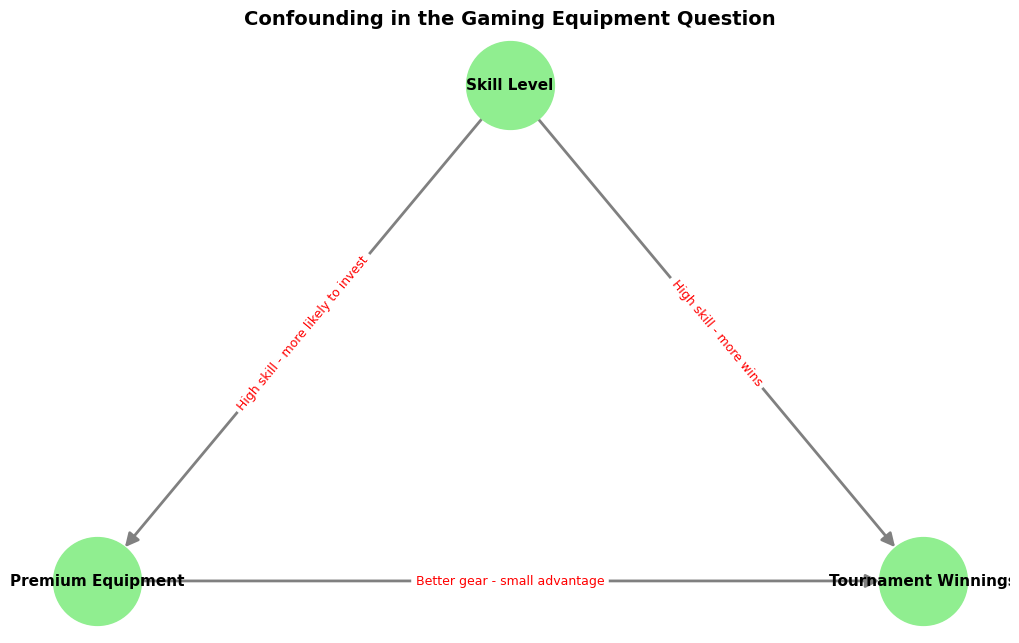

In [ ]:
import networkx as nx

# Create causal diagram
G = nx.DiGraph()
G.add_edges_from([
    ("Skill Level", "Premium Equipment"),
    ("Skill Level", "Tournament Winnings"),
    ("Premium Equipment", "Tournament Winnings")
])

pos = {
    "Skill Level": (0, 1),
    "Premium Equipment": (-1, 0),
    "Tournament Winnings": (1, 0)
}

plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=4000, node_color="lightgreen", 
        font_size=11, font_weight="bold", arrows=True, arrowsize=20,
        edge_color='gray', width=2)

# Add edge labels
edge_labels = {
    ("Skill Level", "Premium Equipment"): "High skill - more likely to invest",
    ("Skill Level", "Tournament Winnings"): "High skill - more wins",
    ("Premium Equipment", "Tournament Winnings"): "Better gear - small advantage"
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_color="red")
plt.title("Confounding in the Gaming Equipment Question", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

**The challenge**: Skill level is a **confounder** - it affects both equipment choice and winnings. Simply comparing premium vs. basic equipment users will overstate the causal effect of equipment.

### Simulation: Creating Our Data

Let's simulate 1000 gamers with varying skill levels.

In [21]:
np.random.seed(42)
n = 1000

# Step 1: Simulate skill level (0 = casual, 1 = dedicated)
skill = np.random.binomial(1, 0.3, n)  # 30% dedicated, 70% casual

# Step 2: Equipment choice depends on skill
# Dedicated players: 80% buy premium equipment
# Casual players: 20% buy premium equipment
prob_premium = 0.8 * skill + 0.2 * (1 - skill)
premium_equipment = np.random.binomial(1, prob_premium, n)

# Step 3: Generate winnings (the outcome)
# Base winnings + skill effect + equipment effect + noise
noise = np.random.normal(0, 500, n)
winnings_observed = (1000 +                      # base winnings
                     3000 * skill +              # skill effect (large!)
                     800 * premium_equipment +   # equipment effect (smaller)
                     noise)

# Step 4: Generate potential outcomes (counterfactuals)
# What would everyone earn WITH premium equipment?
winnings_with_premium = 1000 + 3000 * skill + 800 * 1 + noise

# What would everyone earn WITHOUT premium equipment?
winnings_no_premium = 1000 + 3000 * skill + 800 * 0 + noise

# Create DataFrame
df = pd.DataFrame({
    'Skill': skill,
    'Premium_Equipment': premium_equipment,
    'Winnings_Observed': winnings_observed,
    'Winnings_With_Premium': winnings_with_premium,
    'Winnings_No_Premium': winnings_no_premium
})

print(df.head(10))

   Skill  Premium_Equipment  Winnings_Observed  Winnings_With_Premium  \
0      0                  0         561.008707            1361.008707   
1      1                  1        4386.559823            4386.559823   
2      1                  0        3886.760554            4686.760554   
3      0                  0        1183.682753            1983.682753   
4      0                  1        2256.792313            2256.792313   
5      0                  0         598.410525            1398.410525   
6      0                  0        1746.344284            2546.344284   
7      1                  0        3864.438199            4664.438199   
8      0                  0         989.316353            1789.316353   
9      1                  1        4426.394160            4426.394160   

   Winnings_No_Premium  
0           561.008707  
1          3586.559823  
2          3886.760554  
3          1183.682753  
4          1456.792313  
5           598.410525  
6          1746.34428

**Key features of the data:**
- `Skill`: 0 = casual player, 1 = dedicated player
- `Premium_Equipment`: 0 = basic equipment, 1 = premium equipment
- `Winnings_Observed`: What we actually observe (depends on their actual equipment choice)
- `Winnings_With_Premium`: Counterfactual - what they would earn with premium equipment
- `Winnings_No_Premium`: Counterfactual - what they would earn with basic equipment

In reality, we only see `Winnings_Observed`. We're simulating counterfactuals to understand the true causal effect.

### Visualizing the Confounding Variable

Let's see how skill, equipment, and winnings relate:

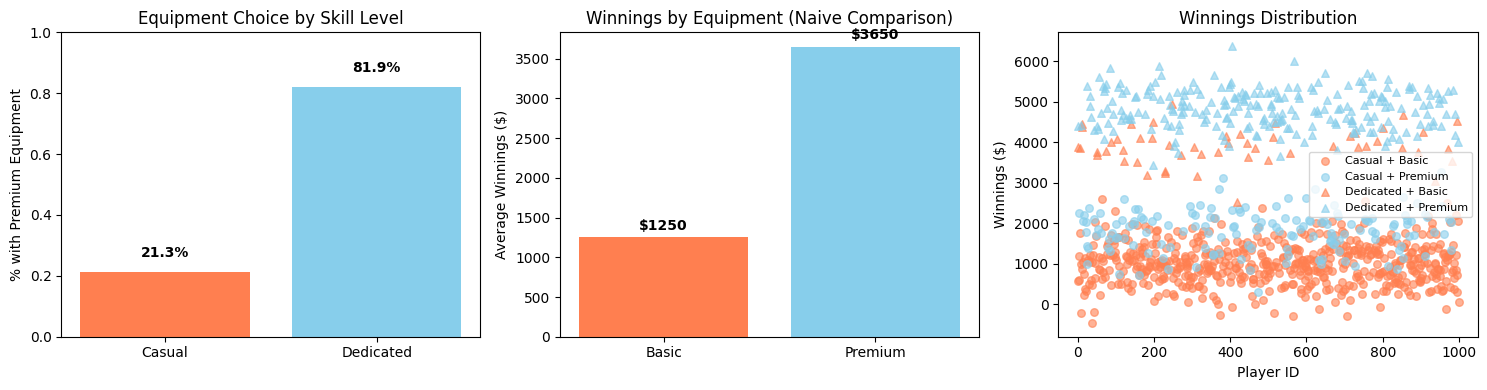

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Equipment by skill level
skill_labels = ['Casual', 'Dedicated']
equipment_by_skill = df.groupby('Skill')['Premium_Equipment'].mean()
axes[0].bar(skill_labels, equipment_by_skill, color=['coral', 'skyblue'])
axes[0].set_ylabel('% with Premium Equipment')
axes[0].set_title('Equipment Choice by Skill Level')
axes[0].set_ylim([0, 1])
for i, v in enumerate(equipment_by_skill):
    axes[0].text(i, v + 0.05, f'{v:.1%}', ha='center', fontweight='bold')

# Plot 2: Winnings by equipment (naive comparison)
winnings_by_equipment = df.groupby('Premium_Equipment')['Winnings_Observed'].mean()
equipment_labels = ['Basic', 'Premium']
axes[1].bar(equipment_labels, winnings_by_equipment, color=['coral', 'skyblue'])
axes[1].set_ylabel('Average Winnings ($)')
axes[1].set_title('Winnings by Equipment (Naive Comparison)')
for i, v in enumerate(winnings_by_equipment):
    axes[1].text(i, v + 100, f'${v:.0f}', ha='center', fontweight='bold')

# Plot 3: Scatter plot showing the confounding
for skill_val in [0, 1]:
    for equip_val in [0, 1]:
        subset = df[(df['Skill'] == skill_val) & (df['Premium_Equipment'] == equip_val)]
        marker = '^' if skill_val == 1 else 'o'
        color = 'skyblue' if equip_val == 1 else 'coral'
        label = f"{'Dedicated' if skill_val else 'Casual'} + {'Premium' if equip_val else 'Basic'}"
        axes[2].scatter(subset.index, subset['Winnings_Observed'], 
                       marker=marker, c=color, alpha=0.6, s=30, label=label)

axes[2].set_xlabel('Player ID')
axes[2].set_ylabel('Winnings ($)')
axes[2].set_title('Winnings Distribution')
axes[2].legend(fontsize=8)

plt.tight_layout()
plt.show()

**What do you see?**
- Dedicated players (80%) are much more likely to buy premium equipment than casual players (20%)
- Premium equipment users earn much more on average ($3500+ vs $1500)
- But is this all due to the equipment, or is it confounded by skill?

### Computing the True Causal Effects

Since we simulated the data, we know the potential outcomes. Let's compute the true causal effects:

In [23]:
# TRUE causal effects (using potential outcomes)
ATE = (df['Winnings_With_Premium'] - df['Winnings_No_Premium']).mean()
ATT = (df[df['Premium_Equipment'] == 1]['Winnings_With_Premium'] - 
       df[df['Premium_Equipment'] == 1]['Winnings_No_Premium']).mean()
ATU = (df[df['Premium_Equipment'] == 0]['Winnings_With_Premium'] - 
       df[df['Premium_Equipment'] == 0]['Winnings_No_Premium']).mean()

print("=" * 60)
print("TRUE CAUSAL EFFECTS")
print("=" * 60)
print(f"Average Treatment Effect (ATE): ${ATE:.2f}")
print(f"  → Effect of premium equipment averaged across ALL players")
print(f"\nEffect on equipment buyers (ATT): ${ATT:.2f}")
print(f"  → Effect for those who actually bought premium equipment")
print(f"\nEffect on non-buyers (ATU): ${ATU:.2f}")
print(f"  → Effect for those who kept basic equipment")
print("=" * 60)
print("\nThe true effect of equipment is $800 (what we built in)")
print("All three are equal because equipment effect is the same for everyone")

TRUE CAUSAL EFFECTS
Average Treatment Effect (ATE): $800.00
  → Effect of premium equipment averaged across ALL players

Effect on equipment buyers (ATT): $800.00
  → Effect for those who actually bought premium equipment

Effect on non-buyers (ATU): $800.00
  → Effect for those who kept basic equipment

The true effect of equipment is $800 (what we built in)
All three are equal because equipment effect is the same for everyone


**Interpretation:**
- **ATE ≈ $800**: On average, premium equipment increases winnings by $800 for anyone
- **ATT ≈ $800**: For those who bought premium equipment, the causal effect is $800
- **ATU ≈ $800**: For those who didn't buy it, the effect would still be $800 if they did

**Why are they equal?** In our simulation, the equipment effect is the same for everyone ($800). In reality, effects might vary - dedicated players might benefit more from better equipment than casual players. Then ATT ≠ ATU.

### The Bias from Naive Comparison

Now let's see what happens if we naively compare premium vs. basic equipment users:

In [24]:
# BIASED estimate: simple difference in means
naive_effect = (df[df['Premium_Equipment'] == 1]['Winnings_Observed'].mean() - 
                df[df['Premium_Equipment'] == 0]['Winnings_Observed'].mean())

print("=" * 60)
print("NAIVE COMPARISON (BIASED)")
print("=" * 60)
print(f"Naive effect estimate: ${naive_effect:.2f}")
print(f"True effect (ATE): ${ATE:.2f}")
print(f"BIAS: ${naive_effect - ATE:.2f}")
print("=" * 60)
print(f"\nThe naive comparison overstates the effect by ${naive_effect - ATE:.0f}!")
print("Most of the difference is due to skill, not equipment.")

NAIVE COMPARISON (BIASED)
Naive effect estimate: $2400.03
True effect (ATE): $800.00
BIAS: $1600.03

The naive comparison overstates the effect by $1600!
Most of the difference is due to skill, not equipment.


**The problem**: Premium equipment users earn much more ($2000+ difference), but most of this is due to higher skill, not the equipment itself! The true equipment effect is only $800.

### Solution: Control for Skill Level

Let's condition on skill level - compare players with the same skill:

In [25]:
print("=" * 60)
print("CONDITIONING ON SKILL LEVEL")
print("=" * 60)

# For casual players (skill = 0)
casual_effect = (df[(df['Premium_Equipment'] == 1) & (df['Skill'] == 0)]['Winnings_Observed'].mean() - 
                 df[(df['Premium_Equipment'] == 0) & (df['Skill'] == 0)]['Winnings_Observed'].mean())
print(f"Effect for casual players (Skill=0): ${casual_effect:.2f}")

# For dedicated players (skill = 1)
dedicated_effect = (df[(df['Premium_Equipment'] == 1) & (df['Skill'] == 1)]['Winnings_Observed'].mean() - 
                    df[(df['Premium_Equipment'] == 0) & (df['Skill'] == 1)]['Winnings_Observed'].mean())
print(f"Effect for dedicated players (Skill=1): ${dedicated_effect:.2f}")

print("=" * 60)
print(f"\nBoth are close to the true effect of ${ATE:.2f}!")
print("By conditioning on skill, we've eliminated confounding bias.")

CONDITIONING ON SKILL LEVEL
Effect for casual players (Skill=0): $812.02
Effect for dedicated players (Skill=1): $930.57

Both are close to the true effect of $800.00!
By conditioning on skill, we've eliminated confounding bias.


**Key insight**: Within each skill level, the equipment effect is around $800 - the true causal effect! 

By conditioning on skill, we achieve:
$$\text{Premium Equipment} \perp U \mid \text{Skill}$$

Within skill groups, equipment choice is "as-if random" with respect to other factors affecting winnings.

### Regression Without Controls (Biased)

Let's see this in regression form:

In [26]:
# Regression without controlling for skill
model_biased = sm.ols(formula='Winnings_Observed ~ Premium_Equipment', data=df).fit()
print(model_biased.summary())

                            OLS Regression Results                            
Dep. Variable:      Winnings_Observed   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     923.4
Date:                Fri, 24 Oct 2025   Prob (F-statistic):          3.95e-144
Time:                        10:50:38   Log-Likelihood:                -8522.1
No. Observations:                1000   AIC:                         1.705e+04
Df Residuals:                     998   BIC:                         1.706e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1249.6523     49.19

In [27]:
# Regression controlling for skill
model_unbiased = sm.ols(formula='Winnings_Observed ~ Premium_Equipment + Skill', data=df).fit()
print(model_unbiased.summary())

                            OLS Regression Results                            
Dep. Variable:      Winnings_Observed   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     5446.
Date:                Fri, 24 Oct 2025   Prob (F-statistic):               0.00
Time:                        10:50:47   Log-Likelihood:                -7610.3
No. Observations:                1000   AIC:                         1.523e+04
Df Residuals:                     997   BIC:                         1.524e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           996.8580     20.08

**Result**: The coefficient on `Premium_Equipment` is now close to $800 - the true causal effect!

**What changed?**
- **Without controls**: We compared all premium users vs. all basic users (confounded by skill)
- **With controls**: We compared premium vs. basic users **with the same skill level** (conditional independence)

The coefficient on `Skill` shows that dedicated players earn ~$3000 more than casual players, holding equipment constant.

By including `Skill` in the regression, we achieve:
$$\text{Premium Equipment} \perp U \mid \text{Skill}$$

### Visual Summary

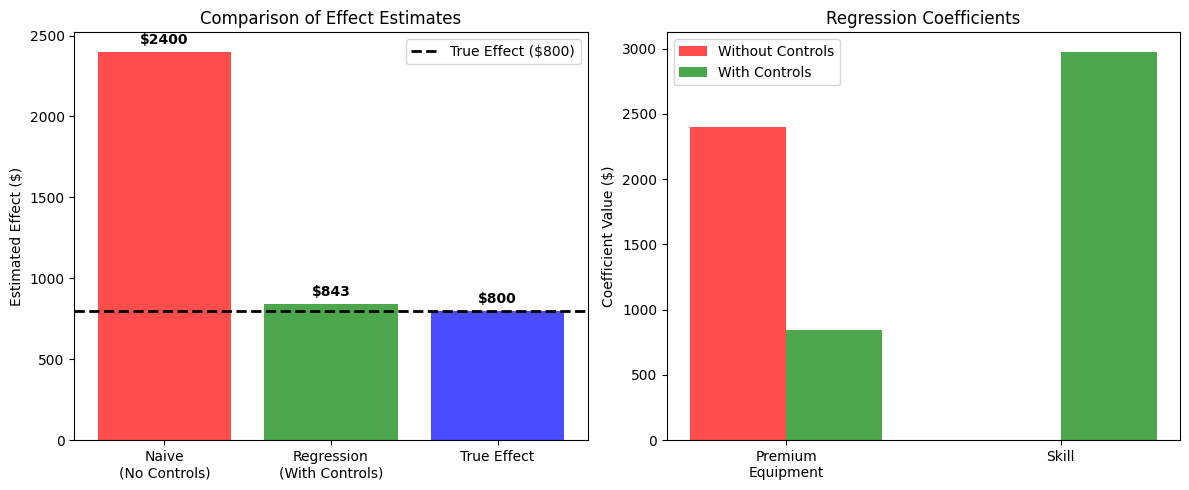

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Comparison of estimates
estimates = ['Naive\n(No Controls)', 'Regression\n(With Controls)', 'True Effect']
values = [naive_effect, model_unbiased.params['Premium_Equipment'], ATE]
colors_bar = ['red', 'green', 'blue']

axes[0].bar(estimates, values, color=colors_bar, alpha=0.7)
axes[0].axhline(y=800, color='black', linestyle='--', linewidth=2, label='True Effect ($800)')
axes[0].set_ylabel('Estimated Effect ($)')
axes[0].set_title('Comparison of Effect Estimates')
axes[0].legend()
for i, v in enumerate(values):
    axes[0].text(i, v + 50, f'${v:.0f}', ha='center', fontweight='bold')

# Coefficient comparison
coef_names = ['Premium\nEquipment', 'Skill']
coef_without = [model_biased.params['Premium_Equipment'], 0]  # No skill in model
coef_with = [model_unbiased.params['Premium_Equipment'], model_unbiased.params['Skill']]

x = np.arange(len(coef_names))
width = 0.35

axes[1].bar(x - width/2, coef_without, width, label='Without Controls', color='red', alpha=0.7)
axes[1].bar(x + width/2, coef_with, width, label='With Controls', color='green', alpha=0.7)
axes[1].set_ylabel('Coefficient Value ($)')
axes[1].set_title('Regression Coefficients')
axes[1].set_xticks(x)
axes[1].set_xticklabels(coef_names)
axes[1].legend()
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

---

### Association vs. Causation

**Association** measures how two variables co-vary, without making causal claims. When we compute:
$$E[Y|S=1] - E[Y|S=0]$$

This is the **associational difference** - how much higher outcomes are for treated vs. control groups. But this mixes:
1. The **causal effect** of treatment
2. **Selection bias** from pre-existing differences between groups

**Causation** requires comparing the same individuals under different treatments (potential outcomes):
$$E[Y(1) - Y(0)]$$

Let's see both in our gaming example:

In [29]:
print("=" * 60)
print("ASSOCIATION vs CAUSATION")
print("=" * 60)

# ASSOCIATION: Observed difference
association = (df[df['Premium_Equipment'] == 1]['Winnings_Observed'].mean() - 
               df[df['Premium_Equipment'] == 0]['Winnings_Observed'].mean())
print(f"\nAssociation (observed difference): ${association:.2f}")
print("  → Premium users earn ${:.0f} more than basic users".format(association))

# CAUSATION: True treatment effect
causation = ATE
print(f"\nCausation (true effect): ${causation:.2f}")
print("  → Premium equipment causes ${:.0f} more winnings".format(causation))

# DECOMPOSE THE ASSOCIATION
print("\n" + "=" * 60)
print("DECOMPOSING THE ASSOCIATION")
print("=" * 60)

# Selection bias component
# What's the difference in skill between equipment groups?
skill_premium = df[df['Premium_Equipment'] == 1]['Skill'].mean()
skill_basic = df[df['Premium_Equipment'] == 0]['Skill'].mean()
skill_diff = skill_premium - skill_basic
selection_bias = skill_diff * 3000  # 3000 is the skill coefficient

print(f"\nSkill composition:")
print(f"  Premium equipment users: {skill_premium:.1%} dedicated")
print(f"  Basic equipment users: {skill_basic:.1%} dedicated")
print(f"  Difference: {skill_diff:.1%}")

print(f"\nSelection bias: ${selection_bias:.2f}")
print(f"  → Premium users are more skilled, worth ${selection_bias:.0f}")

print(f"\nDecomposition:")
print(f"  Association = ${association:.2f}")
print(f"  = Causal effect (${causation:.2f}) + Selection bias (${selection_bias:.2f})")
print(f"  = ${causation:.2f} + ${selection_bias:.2f} ≈ ${association:.2f}")

ASSOCIATION vs CAUSATION

Association (observed difference): $2400.03
  → Premium users earn $2400 more than basic users

Causation (true effect): $800.00
  → Premium equipment causes $800 more winnings

DECOMPOSING THE ASSOCIATION

Skill composition:
  Premium equipment users: 60.8% dedicated
  Basic equipment users: 8.5% dedicated
  Difference: 52.3%

Selection bias: $1569.84
  → Premium users are more skilled, worth $1570

Decomposition:
  Association = $2400.03
  = Causal effect ($800.00) + Selection bias ($1569.84)
  = $800.00 + $1569.84 ≈ $2400.03


**Key insight**: 

The association of $\sim$\$2000 is **NOT** the causal effect. It includes:
- **Causal effect** (\$800): The actual benefit of premium equipment
- **Selection bias** (\$1200+): Premium users are more skilled, which also increases winnings

**Why does this matter?**

If you're a casual player deciding whether to buy premium equipment:
- Looking at association: "Premium users earn \$2000+ more, I should buy it!"
- Looking at causation: "Equipment only adds \$800, most of the difference is skill"

Association misleads us about the causal effect!

### Visualizing Association vs. Causation

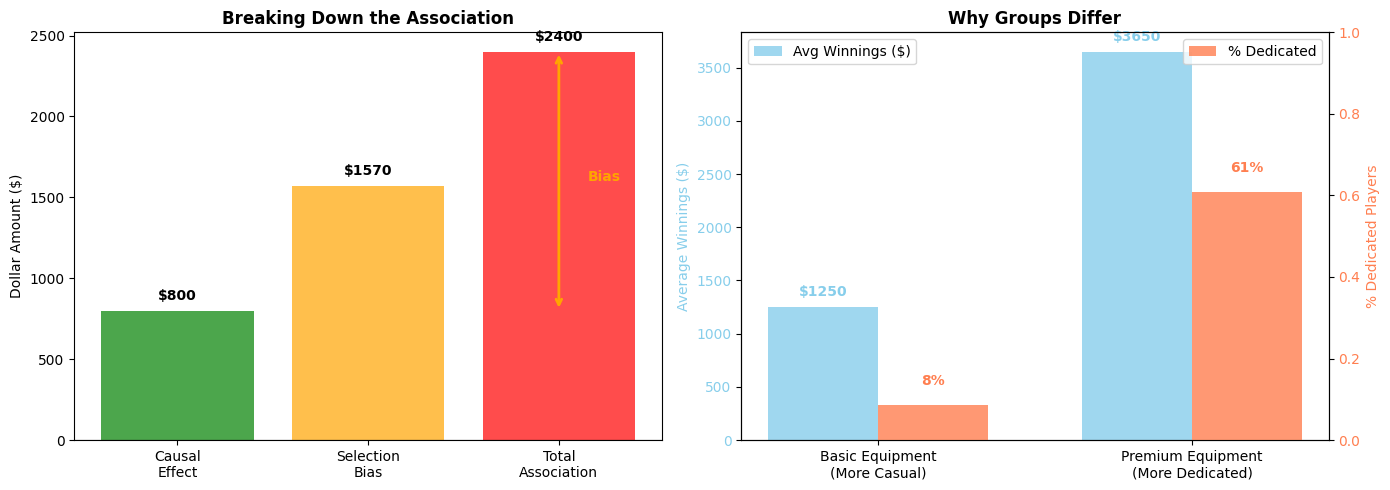

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Breaking down the association
components = ['Causal\nEffect', 'Selection\nBias', 'Total\nAssociation']
values_comp = [causation, selection_bias, association]
colors_comp = ['green', 'orange', 'red']

bars = axes[0].bar(components, values_comp, color=colors_comp, alpha=0.7)
axes[0].set_ylabel('Dollar Amount ($)')
axes[0].set_title('Breaking Down the Association', fontweight='bold')
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

for i, (bar, val) in enumerate(zip(bars, values_comp)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 50,
                f'${val:.0f}', ha='center', va='bottom', fontweight='bold')

# Add annotation
axes[0].annotate('', xy=(2, causation), xytext=(2, association),
                arrowprops=dict(arrowstyle='<->', color='orange', lw=2))
axes[0].text(2.15, (causation + association)/2, 'Bias', fontsize=10, color='orange', fontweight='bold')

# Right plot: Comparing groups
group_labels = ['Basic Equipment\n(More Casual)', 'Premium Equipment\n(More Dedicated)']
avg_winnings = [df[df['Premium_Equipment'] == 0]['Winnings_Observed'].mean(),
                df[df['Premium_Equipment'] == 1]['Winnings_Observed'].mean()]
avg_skill = [df[df['Premium_Equipment'] == 0]['Skill'].mean(),
             df[df['Premium_Equipment'] == 1]['Skill'].mean()]

x_pos = np.arange(len(group_labels))
width = 0.35

bars1 = axes[1].bar(x_pos - width/2, avg_winnings, width, label='Avg Winnings ($)', 
                    color='skyblue', alpha=0.8)
axes[1].set_ylabel('Average Winnings ($)', color='skyblue')
axes[1].tick_params(axis='y', labelcolor='skyblue')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(group_labels)
axes[1].set_title('Why Groups Differ', fontweight='bold')

# Add second y-axis for skill
ax2 = axes[1].twinx()
bars2 = ax2.bar(x_pos + width/2, avg_skill, width, label='% Dedicated', 
                color='coral', alpha=0.8)
ax2.set_ylabel('% Dedicated Players', color='coral')
ax2.tick_params(axis='y', labelcolor='coral')
ax2.set_ylim([0, 1])

# Add values on bars
for i, v in enumerate(avg_winnings):
    axes[1].text(i - width/2, v + 100, f'${v:.0f}', ha='center', fontweight='bold', color='skyblue')
for i, v in enumerate(avg_skill):
    ax2.text(i + width/2, v + 0.05, f'{v:.0%}', ha='center', fontweight='bold', color='coral')

# Add legends
axes[1].legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

**The left plot shows**: Most of the association (\$2000+) comes from selection bias (\$1200+), not the causal effect (\$800).

**The right plot shows**: Premium equipment users earn more AND are more dedicated. Both contribute to higher winnings.

### Why Association Fails for Causal Inference

**The fundamental problem**: When we compute association:
$$E[\text{Winnings}|\text{Premium}] - E[\text{Winnings}|\text{Basic}]$$

We're comparing two **different populations**:
- Premium group: More dedicated players
- Basic group: More casual players

**What we want** is to compare the **same population** under different treatments:
$$E[\text{Winnings with Premium}] - E[\text{Winnings with Basic}]$$

Without controlling for skill, association ≠ causation.

---

### Key Takeaways

1. **Confounding creates bias**: Naive comparisons mix the true treatment effect with differences in confounders

2. **Conditional independence is key**: Control variables work when $S \perp U \mid C$ (treatment is independent of unobserved factors, conditional on controls)

3. **Regression with controls**: Including confounders in regression achieves conditioning - we compare observations with the same confounder values

4. **The critical assumption**: This only works if we've measured and controlled for ALL confounders. If there are unmeasured confounders, bias remains.

**Next steps**: How do we choose which variables to control for? When is conditional independence plausible?

---

## Next Recitation 

+ Explore more about control varaibles 

### Office hours Monday 3PM - 4PM  Room No - 244
### or drop in your questions at vka244@nyu.edu